# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `19`
* Students: `Fengyu CAI`, `Liangwei CHEN`, `Junze LI`, `Wanhao ZHOU`

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [4]:
column_list = ['paper_id'] + ['word_attributes_' + str(i) for i in range(1433)] + ['class_label']
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 
pd_content.head()

,paper_id,word_attributes_0,word_attributes_1,word_attributes_2,word_attributes_3,word_attributes_4,word_attributes_5,word_attributes_6,word_attributes_7,word_attributes_8,...,word_attributes_1424,word_attributes_1425,word_attributes_1426,word_attributes_1427,word_attributes_1428,word_attributes_1429,word_attributes_1430,word_attributes_1431,word_attributes_1432,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [5]:
pd_content['class_label'].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [13]:
my_field = "Rule_Learning"
features = pd_content.loc[pd_content.class_label == my_field].iloc[:, 1:-1].values
features.shape

(180, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [14]:
b1 = features.reshape((1, features.shape[0], features.shape[1]))
b2 = features.reshape((features.shape[0], 1, features.shape[1]))
distance = np.sqrt(np.sum(np.square(b1 - b2), 2))
distance.shape

Check the mean pairwise distance $\mathbb{E}[D]$.

In [18]:
mean_distance = distance.mean()
mean_distance

5.822492039380866

Plot an histogram of the euclidean distances.

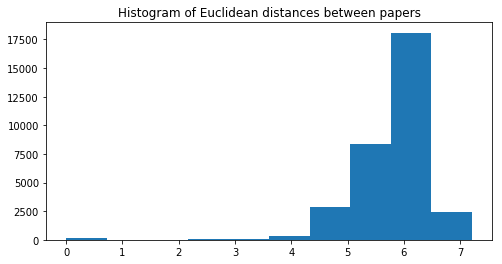

In [19]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [23]:
threshold = mean_distance
A_feature = (distance < mean_distance) * (1 - np.identity(distance.shape[0]))

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [25]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')

num_papers = pd_content.shape[0]
A_citation = np.zeros((num_papers, num_papers))

for p in cora_cites:
    cited = pd_content[pd_content.paper_id == int(p[0])]
    citing = pd_content[pd_content.paper_id == int(p[1])]
    
    A_citation[citing.index[0], cited.index[0]] = 1

A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [26]:
indices = np.array(pd_content.index[pd_content['class_label'] == my_field])
A_citation = A_citation[indices][:,indices]

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [27]:
A_citation = np.maximum( A_citation, A_citation.transpose() )
np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [28]:
A_citation.shape

(180, 180)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [29]:
num_edges_feature = np.sum(A_feature > 0) / 2
num_edges_citation = np.sum(A_citation > 0) / 2
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 5829.0
Number of edges in the citation graph: 253.0


Plot the degree distribution histogram for each of the graphs.

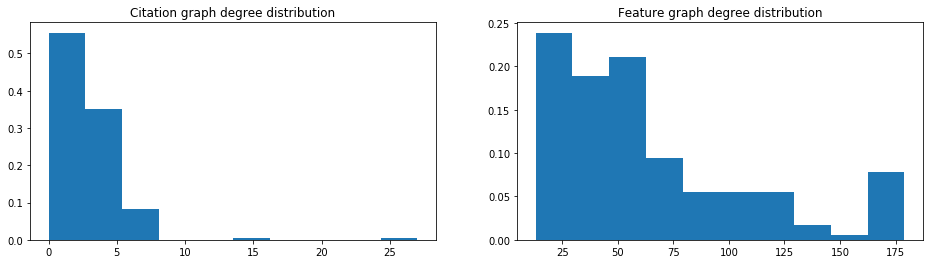

In [30]:
degrees_citation = np.sum(A_citation > 0, axis = 1)
degrees_feature = np.sum(A_feature > 0, axis = 1)

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [31]:
cit_moment_1 = np.mean(degrees_citation)
cit_moment_2 = np.mean(np.square(degrees_citation))

feat_moment_1 = np.mean(degrees_feature)
feat_moment_2 = np.mean(np.square(degrees_feature))

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 2.811111111111111
2nd moment of citation graph: 15.233333333333333
1st moment of feature graph: 64.76666666666667
2nd moment of feature graph: 6183.166666666667


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**

The first moment is the mean of statistics. It shows the center of the distribution. And the second moment indicates the variance of statistics, showing the spread of the distribution.

From citation degree distribution, most of the samples are located in the range from 0 to 10. Therefore, both the first moment and the second moment are low. Meanwhile, the second moment of feature graph degree distribution is very high because the samples are spread widely.

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

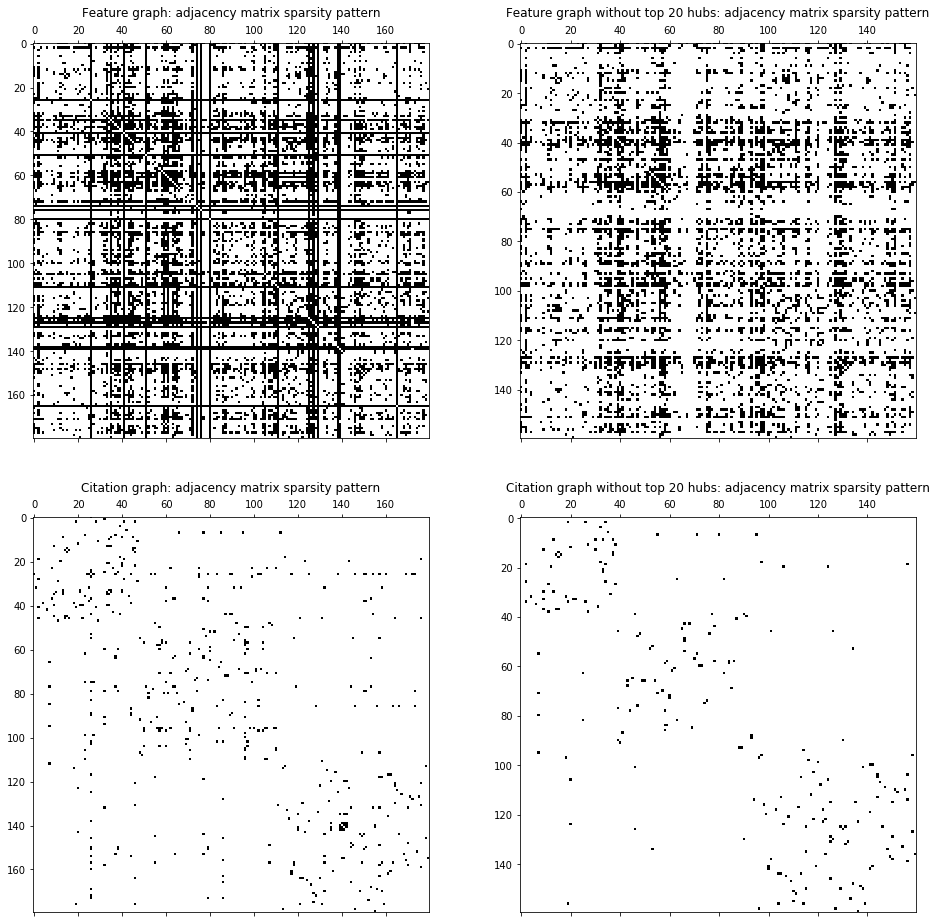

In [55]:
feature_hub_indices = np.argsort(degrees_feature)[: : -1][: 20]
reduced_A_feature = np.delete(np.delete(A_feature,
                                        obj = feature_hub_indices,
                                       axis = 0),
                              obj = feature_hub_indices,
                              axis = 1)
citation_hub_indices = np.argsort(degrees_citation)[: : -1][: 20]
reduced_A_citation = np.delete(np.delete(A_citation,
                                        obj = citation_hub_indices,
                                        axis = 0),
                              obj = citation_hub_indices,
                              axis = 1)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

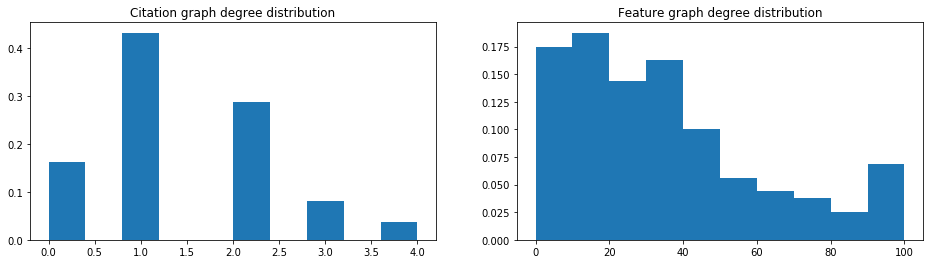

In [57]:
reduced_degrees_feat = np.sum(reduced_A_feature, axis = 1)
reduced_degrees_cit = np.sum(reduced_A_citation, axis = 1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [58]:
reduced_cit_moment_1 = np.mean(reduced_degrees_cit)
reduced_cit_moment_2 = np.mean(np.square(reduced_degrees_cit))

reduced_feat_moment_1 = np.mean(reduced_degrees_feat)
reduced_feat_moment_2 = np.mean(np.square(reduced_degrees_feat))


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.4
Citation graph second moment: 2.9125
Feature graph first moment:  34.1875
Feature graph second moment:  1870.2125


Print the number of edges in the reduced graphs.

In [63]:
print(f"Number of edges in reduced citation graph is {np.sum(reduced_degrees_cit) / 2}")
print(f"Number of edges in reduced feature graph is {np.sum(reduced_degrees_feat) / 2}")

Number of edges in reduced citation graph is 112.0
Number of edges in reduced feature graph is 2735.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**Your answer here:**

In [74]:
# Illustrate the percentage change of each moment after removing hubs
print(f"The change of 1st moment of Citation graph is {'{:.1%}'.format(1 - \
        reduced_cit_moment_1 / cit_moment_1)}")
print(f"The change of 2nd moment of Citation graph is {'{:.1%}'.format(1 -\
        reduced_cit_moment_2 / cit_moment_2)}")
print(f"The change of 1st moment of Feature graph is {'{:.1%}'.format(1 - \
        reduced_feat_moment_1 / feat_moment_1)}")
print(f"The change of 2nd moment of Feature graph is {'{:.1%}'.format(1 - \
        reduced_feat_moment_2 / feat_moment_2)}")

The change of 1st moment of Citation graph is 50.2%
The change of 2nd moment of Citation graph is 80.9%
The change of 1st moment of Feature graph is 47.2%
The change of 2nd moment of Feature graph is 69.8%


The effect of removing hubs are not the same for both networks.

From the figures above one may observe that the second moment of citation graph is affected the most.

The reason for larger effect in Citation graph than that in Feature graph is that the Citation graph is smaller than the Feature graph, thus with worse stability. Moreover, the degree distribution in Citation graph is more concentrated on low degree part than that in Feature graph, and thus has greater change after removing outliers with high degree.

The reason for larger effect in the second moment thatn that in the first moment is that the squaring operation enlarge the influence of nodes with larger degrees, which are outliers in above cases, on the moment computation.

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [85]:
threshold = 0.75 * mean_distance

A_feature_pruned = (distance < threshold) * (1 - np.identity(distance.shape[0]))
num_edges_feature_pruned = np.sum(A_feature_pruned) / 2

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 5829.0
Number of edges in the feature graph after pruning: 314.0
Number of edges in the citation graph: 253.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

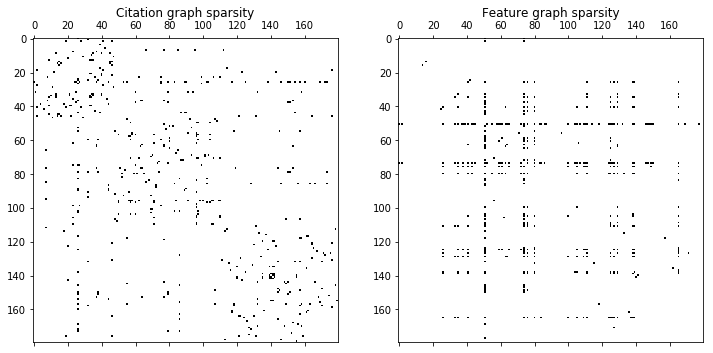

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [109]:
path_matrix_citation = np.sum([np.linalg.matrix_power(A_citation, n) for n in np.arange(1, N + 1)],
                             axis = 0)
path_matrix_feature = np.sum([np.linalg.matrix_power(A_feature, n) for n in np.arange(1, N + 1)],
                            axis = 0)

Check the sparsity pattern for both of path matrices.

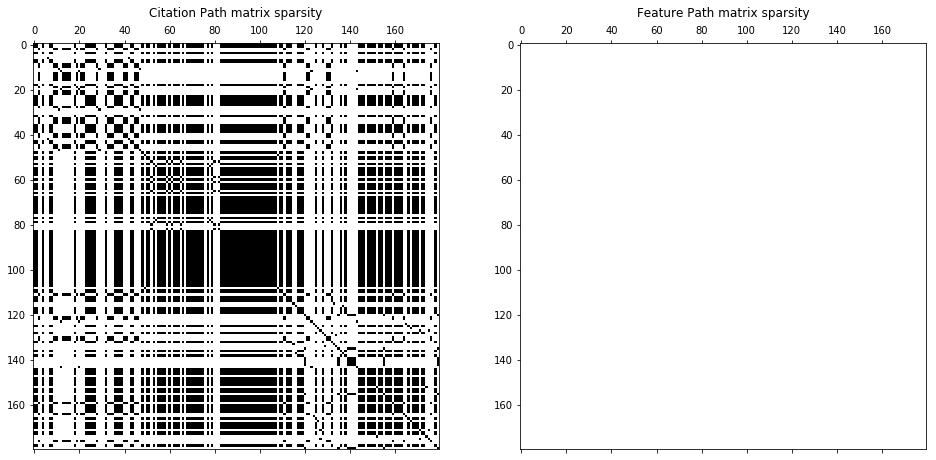

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

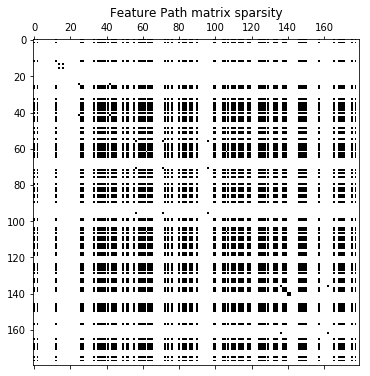

In [111]:
path_matrix_pruned = np.sum([np.linalg.matrix_power(A_feature_pruned, n) for n in np.arange(1, N + 1)],
                           axis = 0)
plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**

Yes. The prunned feature path matrix has more zero entries than unprunned one, which indicates that the unprunned graph has greater sparsity than its unprunned version.

****

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** 

For an undirected graph $G(V, E)$, it is connected iff $\forall v, w \in V, \exists p$ with length $|V| - 1$ such that p's two ends are $v, w$

Thus one may compute the path matrix $P$ with $N$ from 1 to $|V| - 1$ and the graph is connected iff $\exists N s.t. \forall i, j; P(i, j) > 0$

Since for $N = 10$, the original feature graph already leads to path matrix with $\forall i, j; P(i, j) > 0$, the path matrix with $N = |V| - 1$ definitely has all entries positive. Thus it is connected.

****

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**

Starting with $N=1$, compute the path matrix with increasing $N$ by one each step. The first $N$ s.t. the path matrix has all entries positive is a diameter of the graph.

If any of your graphs is connected, calculate the diameter using that process.

In [112]:
# Only calculate the diameter of unprunned feature graph
for i in np.arange(1, N):
    
    # Calculate Path matrix with N = i
    path_matrix = np.sum([np.linalg.matrix_power(A_feature, i) for j in np.arange(1, i + 1)], axis = 0)
    
    if np.count_nonzero(path_matrix) == path_matrix.shape[0] * path_matrix.shape[1]:
        diameter = i
        break
print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [113]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [114]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [115]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 180, Number of edges: 253
Number of self-loops: 0, Number of connected components: 26


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [116]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 180, Number of edges: 314
Number of self-loops: 0, Number of connected components: 101


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [117]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

180

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [118]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

284.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**

The resulting graph should have expected number of edges matches the average number of edges in the citation
and the feature graph.

Thus it should statisfies $p*\binom{n}{2}=m$

In [287]:
p = 2 * m / (n * (n - 1))
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [142]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 288 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:**

According to the implementation of Barabasi-Albert graph, the number of edges in the resulting graphs is
$(n-q)*q$, thus to match the number of edges in the original graph, one has to set q s.t. $(n-q)*q=m$, which means q should be $\frac{n - \sqrt{n^2 - 4m}}{2}$. 

Since q is number of edges to be added each step, it is indeed an integer. Thus we round it to the nearest integer at the end of calculation.

In [288]:
q = int(np.rint((n - np.sqrt(n ** 2 - 4 * m)) / 2))
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [289]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 356 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [162]:
giant_citation = G_citation.subgraph(sorted(nx.connected_components(G_citation),
                                            key = len,
                                            reverse = True)[0])
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 102 nodes and 172 edges.


In [165]:
giant_feature = G_feature.subgraph(sorted(nx.connected_components
                                          (G_feature),
                                         key = len,
                                         reverse = True)[0])
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 73 nodes and 307 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [166]:
giant_er = G_er.subgraph(sorted(nx.connected_components(G_er),
                               key = len,
                               reverse = True)[0])
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 177 nodes and 288 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**

Let $s$ denotes fractions of nodes in giant component, then it satisfies $s = 1 - e^{-p(n - 1)s}$.

To match the size of giant component in the original graph, s also needs to satisfy $n * s = |GC\_original|$.

Thus one may solve the above two equations to get appropriate p.

****

In [219]:
# Get fraction of nodes in GC
s = giant_feature.number_of_nodes() / G_citation.number_of_nodes()
p_new = -np.log(1 - s) / ((n - 1) * s)
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [220]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
G_er_new = nx.erdos_renyi_graph(n, p_new)
giant_er_new = G_er_new.subgraph(sorted(nx.connected_components(G_er_new),
                                       key = len,
                                       reverse = True)[0])
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 132 edges.
The giant component of the new Erdos-Rényi network has 100 nodes and 104 edges.


### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

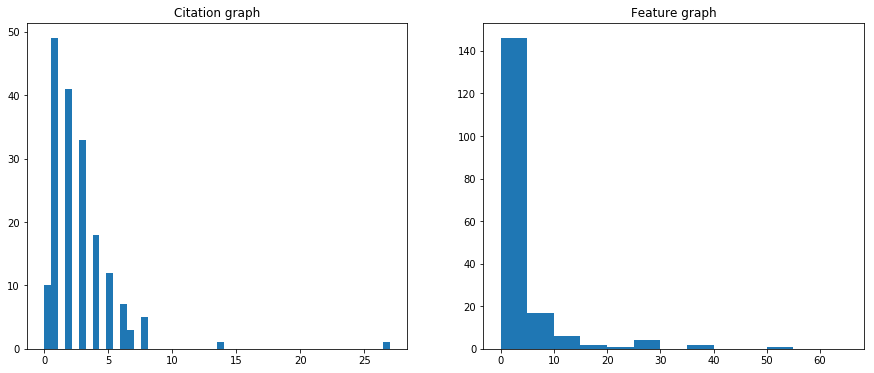

In [284]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = np.asarray(list(G_citation.degree))[:, 1]
axes[0].hist(citation_degrees, bins = 50);
axes[1].set_title('Feature graph')
feature_degrees = np.asarray(list(G_feature.degree))[:, 1]
axes[1].hist(feature_degrees, bins = np.arange(0, 70, 5));

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**

The degree distribution can indicate the category of the network.

From the histogram of degrees above, one may observe that the citation graph has degree distribution fitting a Poisson and thus should be the result of a random network.

Meanwhile the degree distribution in the feature graph fits power-law distribution and thus should be the result of a scale free network.

****

Now, plot the degree distribution historgrams for the simulated networks.

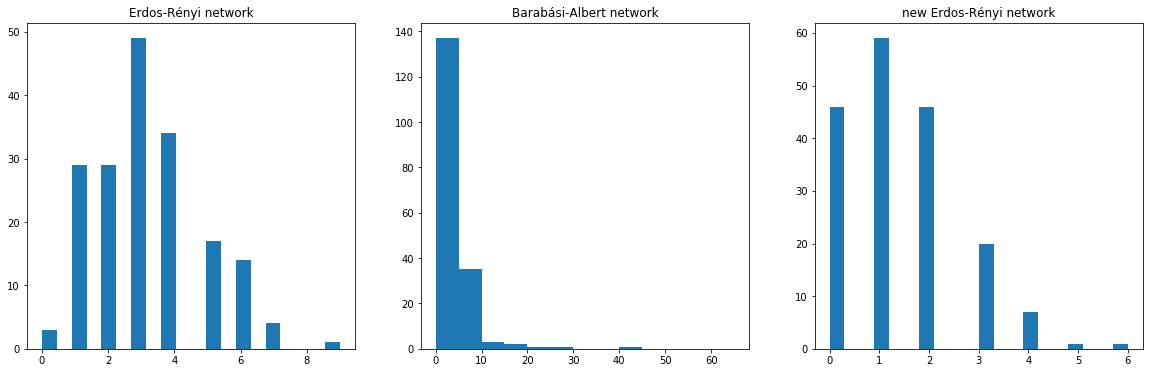

In [282]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = np.asarray(list(G_er.degree))[:, 1]
axes[0].hist(er_degrees, bins = 20);
axes[1].set_title('Barabási-Albert network')
ba_degrees = np.asarray(list(G_ba.degree))[:, 1]
axes[1].hist(ba_degrees, bins = np.arange(0, 70, 5));
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = np.asarray(list(G_er_new.degree))[:, 1]
axes[2].hist(er_new_degrees, bins = 20);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** 

By comparison between degree distribution of simulated and original graphs, one may see thath Erdos-Renyi network matches citation distribution well while Barabasi-Albert network matches feature distribution well.

The new Erdos-Renyi network matches citation network best in terms of degree distribution.

****

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [222]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 180 nodes and 314 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** 

No.

One counter example can be generated with each node having two edges incident to it. Since the function may generate a graph with self-loop and parallel edges, a ring and an isolated graph with each node only has two parallel edges incident to it are regarded as the same. Thus the feature graph and the graph generated by the configuration model may not necessarily be identical.

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [223]:
nx.average_clustering(G_citation)

0.26935863519196857

In [224]:
nx.average_clustering(G_feature)

0.25472338886348894

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

In [233]:
print(f"Number of connected components in G_citation is {len(list(nx.connected_components(G_citation)))}")
print(f"Number of connected components in G_feature is {len(list(nx.connected_components(G_feature)))}")

Number of connected components in G_citation is 26
Number of connected components in G_feature is 101


**Your answer here:**

The clustering coefficient is an indicator of a network's density. The higher the coefficient, the denser the network. If the clustering coefficient is 1, the network is a complete graph.

Even though citation graph and feature graph have similar small avg clustering coefficient, one may observe that the feature graph has much more connected components than citation graph. The great difference between number of connected components indicates that the avg clustering coefficient may not be a good metric to measure the difference between density of two graph.

****

Now, let us check the average clustering coefficient for the simulated networks.

In [225]:
nx.average_clustering(G_er)

0.011715167548500882

In [226]:
nx.average_clustering(G_ba)

0.11083201305487292

In [227]:
nx.average_clustering(nx.Graph(G_config))

0.11795276078630723

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

No. The citation and feature graphs have much higher clustering coefficient than that of simulated ones.

Among the above three networks, Erdos-Renyi has least avg clustering coefficient since it is an instance of random network and thus has avg clustering coefficient decreases linearly with respect to the number of nodes

***

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

Since the feature graph follows a power-law distribution and BA model cannot fit the clustering coefficient well, we select the powerlaw_cluster model which take approximating the clustering coefficient into account and ensure power-law distribution at the same time. Based on the above mentioned properties, it can be expected that the new simulating graph will fit the feature graph better in terms of degree distribution and clustering coefficient.

The parameter p of powerlaw_cluster graph is set to be the average clustering coefficient of the original graph. This setting originates from the observation that the higher the avg clustering coefficient, the more likely a triangle should be formed in a good approximation.

*****

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [256]:
# Your code here.
avg_deg = int(np.rint(np.mean(feature_degrees)))
G_better_simulated = nx.powerlaw_cluster_graph(n, q, nx.average_clustering(G_feature))

In [276]:
# Compute the similarity of degree distribution and avg clustering coefficient between 
# original and simulated graph
print(f"The number of edges of original citation graph is {np.sum(feature_degrees)}")
print(f"The number of edges of simulated citation graph is\
 {np.sum(np.asarray(list(G_better_simulated.degree))[:, 1])}")
print(f"The avg clustering coefficient of original graph is {nx.average_clustering(G_feature)}")
print(f"The avg clustering coefficient of simulated graph is {nx.average_clustering(G_better_simulated)}")

The number of edges of original citation graph is 628
The number of edges of simulated citation graph is 712
The avg clustering coefficient of original graph is 0.25472338886348894
The avg clustering coefficient of simulated graph is 0.2177378541577728


In [266]:
original_degs = feature_degrees
simulated_degs = np.asarray(list(G_better_simulated.degree))[:, 1]

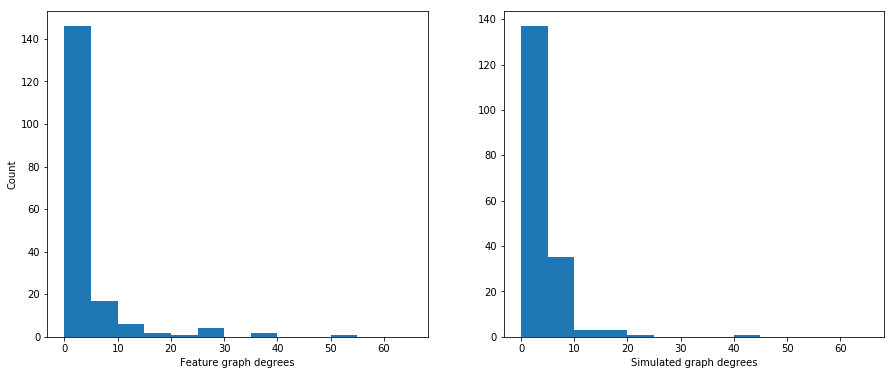

In [272]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
_ = axes[0].hist(original_degs, bins = np.arange(0, 70, 5))
_ = axes[0].set_xlabel("Feature graph degrees")
_ = axes[0].set_ylabel("Count")
_ = axes[1].hist(simulated_degs, bins = np.arange(0, 70, 5))
_ = axes[1].set_xlabel("Simulated graph degrees")

Comment on the similarities of your match.

**Your answer here:**

The powerlaw_cluster model performs similarly in terms of degree distribution to the BA model since they both follow a power distribution. However, it has much closer average clustering coefficient to the original graph than the former model.